In [1]:
import cv2
import numpy as np
import datetime
import time
import re
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# from imutils.video import FileVideoStream
from FileVideoStream import FileVideoStream
from UMatFileVideoStream import UMatFileVideoStream
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from colour import Color

In [2]:
# change matplotlib font
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
# rc('text', usetex=True)

In [3]:
video_path = 'videos/test_bright.mp4'
cap = cv2.VideoCapture(video_path)
VIDEO_LENGTH  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
VIDEO_WIDTH  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
VIDEO_HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
VIDEO_FPS    = cap.get(cv2.CAP_PROP_FPS)
cap.release()

## Find LED position

In [4]:
#check if two keypoint are at the same location with some tolerance
def kp_match(kp1, kp2, tolerance):
    if abs(kp1.pt[0] - kp2.pt[0]) > tolerance:
        return False
    if abs(kp1.pt[1] - kp2.pt[1]) > tolerance:
        return False
    return True

#update the average keypoint location and size
def kp_avg_update(kp_avg, kp_new, count):
    pt0 = (kp_avg.pt[0] * count + kp_new.pt[0]) / (count + 1)
    pt1 = (kp_avg.pt[1] * count + kp_new.pt[1]) / (count + 1)
    kp_avg.pt = (pt0, pt1)
    kp_avg.size = (kp_avg.size * count + kp_new.size) / (count + 1)
    return kp_avg

In [5]:
# Set up the SimpleBlobdetector with default parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0
params.maxThreshold = 256
    
# Filter by Area.
params.filterByArea = True
params.minArea = 50
params.maxArea = 10000
    
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1
    
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.7
    
# Filter by Inertia
params.filterByInertia =True
params.minInertiaRatio = 0.1
    
detector = cv2.SimpleBlobDetector_create(params)

In [6]:
all_keypoints = []
unique_kps = []
blur_size = 61  #must be odd
threshold = 20
morph_open_kernel = np.ones((5,5),np.uint8)
morph_close_kernel = np.ones((2,2),np.uint8)


fvs = UMatFileVideoStream(video_path).start()
time.sleep(0.5)

kp_tolerance = min(VIDEO_HEIGHT, VIDEO_WIDTH) * 0.05

prev_frame = fvs.read()
_, _, prev_frame = cv2.split(cv2.cvtColor(prev_frame,cv2.COLOR_BGR2HSV))
prev_frame = cv2.UMat(cv2.GaussianBlur(prev_frame, (blur_size, blur_size), 0))

frame = cv2.UMat(VIDEO_HEIGHT, VIDEO_WIDTH, cv2.CV_8UC3)
hsv = cv2.UMat(VIDEO_HEIGHT, VIDEO_WIDTH, cv2.CV_8UC3)
v   = cv2.UMat(VIDEO_HEIGHT, VIDEO_WIDTH, cv2.CV_8UC1)
blur = cv2.UMat(VIDEO_HEIGHT, VIDEO_WIDTH, cv2.CV_8UC1)
diff = cv2.UMat(VIDEO_HEIGHT, VIDEO_WIDTH, cv2.CV_8UC1)
thres = cv2.UMat(VIDEO_HEIGHT, VIDEO_WIDTH, cv2.CV_8UC1)
m_open = cv2.UMat(VIDEO_HEIGHT, VIDEO_WIDTH, cv2.CV_8UC1)
m_close = cv2.UMat(VIDEO_HEIGHT, VIDEO_WIDTH, cv2.CV_8UC1)
im = cv2.UMat(VIDEO_HEIGHT, VIDEO_WIDTH, cv2.CV_8UC1)


start_time = time.time()
frame_count = 0
while(frame_count < VIDEO_LENGTH-1):
    frame_count += 1
    frame = fvs.read()
    cv2.cvtColor(frame, cv2.COLOR_BGR2HSV, hsv, 0)
    _, _, v = cv2.split(hsv)
    cv2.GaussianBlur(src=v, ksize=(blur_size, blur_size), sigmaX=0, dst=blur)
    cv2.absdiff(blur, prev_frame, diff)
    prev_frame = cv2.UMat((blur.get()).copy())
    cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY, thres)
    cv2.morphologyEx(thres, cv2.MORPH_CLOSE, morph_close_kernel, m_close)
    cv2.morphologyEx(m_close, cv2.MORPH_OPEN, morph_open_kernel, m_open)
    cv2.bitwise_not(m_open, im)
    keypoints = detector.detect(im) # Detect blobs.
    if keypoints:
        all_keypoints.append(keypoints)
        #for each found keypoint check if it has been previously found
        for new_kp in keypoints:
            found = False
            for i, (avg_kp, kps) in enumerate(unique_kps):
                if kp_match(new_kp, avg_kp, kp_tolerance):
                    avg_kp = kp_avg_update(avg_kp, new_kp, len(kps))
                    kps.append(new_kp)
                    unique_kps[i] = (avg_kp, kps)
                    found = True
                    break
            if not found:
                unique_kps.append((new_kp, [new_kp]))


print("--- %s fps ---" % (frame_count/(time.time() - start_time)))
fvs.stop()

--- 6.782117863219867 fps ---


In [7]:
# cv2.imwrite('images/00_frame.png', frame)
# cv2.imwrite('images/01_hsv.png', hsv)
# cv2.imwrite('images/02_v.png', v)
# cv2.imwrite('images/03_blur.png', blur)
# cv2.imwrite('images/04_diff.png', diff)
# cv2.imwrite('images/05_thres.png', thres)
# cv2.imwrite('images/06_m_open.png', m_open)
# cv2.imwrite('images/07_m_close.png', m_close)
# cv2.imwrite('images/08_im.png', im)
# cv2.imwrite('images/09_keypoints.png', cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

### Show unique keypoints with number of occurences

In [8]:
red = Color("red")
colors = list(red.range_to(Color("green"),10))
color_range = []
for c in colors:
    color_range.append((c.get_blue()*255, c.get_green()*255, c.get_red()*255))
    
unique_kps.sort(key=lambda x: len(x[1]), reverse=True)

kps = [x for x, _ in unique_kps]
kp_count = [len(x) for _, x in unique_kps]

bins = np.histogram(kp_count, bins=9)[1]
color_id = np.digitize(kp_count, bins=bins) - 1

cap = cv2.VideoCapture(video_path)
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
ret, frame = cap.read()
cap.release()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

color = (0,0,255)   #BGR
frame = cv2.drawKeypoints(frame, kps, np.array([]), color, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
for kp, count, c_id in zip(kps, kp_count, color_id):
    frame = cv2.drawKeypoints(frame, [kp], np.array([]), color_range[c_id], cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    text = str(count)
    font = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX
    font_scale = 1
    font_stroke = 2
    textsize = cv2.getTextSize(text, font, font_scale, font_stroke)[0]
    textX = int(kp.pt[0] - textsize[0]/2)
    textY = int(kp.pt[1] + textsize[1]/2)
    cv2.putText(frame, text, (textX,textY), font, font_scale, color_range[c_id], font_stroke)

cv2.imshow('Frame',frame)
cv2.waitKey(0)

-1

In [9]:
# cv2.imwrite('images/keypoints.png', frame)

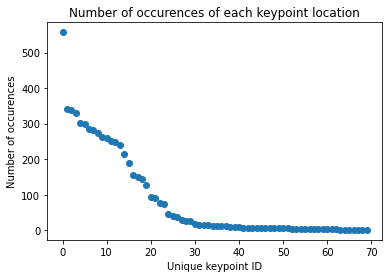

In [10]:
plt.plot(kp_count, 'o')
plt.ylabel('Number of occurences')
plt.xlabel('Unique keypoint ID')
# plt.savefig('images/keypoint_occurences.pdf', bbox_inches='tight', dpi=300)
plt.title('Number of occurences of each keypoint location')

# axes_color = '#40c6cc'
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)

# plt.savefig('images/keypoint_occurences.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

## Determine LED brightness and blinking pattern

In [12]:
kp = kps[0]
led = []

expansion = 0.8
blur_size = 61
threshold = 20
morph_open_kernel = np.ones((4,4),np.uint8)
morph_close_kernel = np.ones((2,2),np.uint8)

x = int(kp.pt[0])
y = int(kp.pt[1])
radius = int(kp.size / 2 * expansion)
x_min = max(x - radius, 0)
x_max = min(x + radius, VIDEO_WIDTH)
y_min = max(y - radius, 0)
y_max = min(y + radius, VIDEO_HEIGHT)

mask = np.zeros((radius*2, radius*2), dtype=np.uint8)
cv2.circle(mask, (radius,radius), radius, (255, 255, 255), -1, 8, 0)

fvs = FileVideoStream(video_path).start()
start_time = time.time()
time.sleep(0.1)
frame_count = 0
while(frame_count < VIDEO_LENGTH):
    frame_count += 1
    frame = fvs.read()
    frame = frame[y_min:y_max, x_min:x_max] 
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)[:,:,2] & mask
    frame = cv2.GaussianBlur(frame, (blur_size, blur_size), 0)
    led.append(frame.sum())

print("--- %s fps ---" % (frame_count/(time.time() - start_time)))
cap.release()

--- 73.08187032105391 fps ---


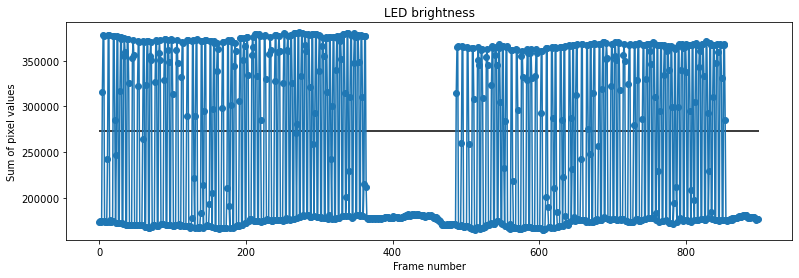

In [13]:
mid_value = np.histogram(led, bins=2)[1][1]
x = np.arange(900)#len(led))
plt.figure(figsize=(13,4))
plt.plot(x,led[:900],marker='o')
plt.hlines(mid_value, xmin=0, xmax=len(x))
plt.xlabel('Frame number')
plt.ylabel('Sum of pixel values')
# plt.savefig('images/led_decode_01.pdf', bbox_inches='tight', dpi=300)
plt.title('LED brightness')

# axes_color = '#40c6cc'
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color)
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color)
# ax.title.set_color(axes_color)

# plt.savefig('images/led_decode_01.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

In [14]:

digitized = np.digitize(led, [mid_value])
digitized[0] = 1
digitized[-1] = 1

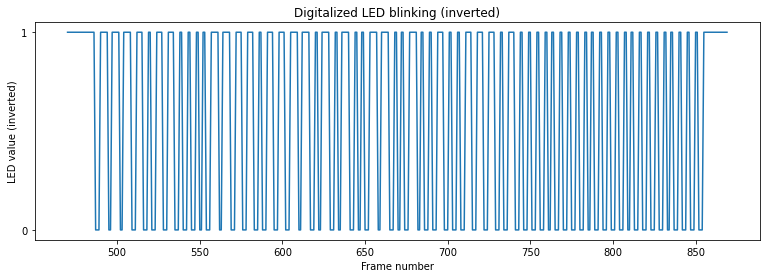

In [15]:
x = np.arange(900)
plt.figure(figsize=(13,4))
plt.plot(x[470:870], (digitized*(-1)+1)[470:870])

plt.yticks([0,1])
plt.xlabel('Frame number')
plt.ylabel('LED value (inverted)')
# plt.savefig('images/led_decode_02_digital.pdf', bbox_inches='tight', dpi=300)
plt.title('Digitalized LED blinking (inverted)')

# axes_color = '#40c6cc'
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color)
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color)
# ax.title.set_color(axes_color)

# plt.savefig('images/led_decode_02_digital.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

## Decode timestamp

In [16]:
_, splits = find_peaks(digitized*(-1),plateau_size=VIDEO_FPS)
led_regions = []
for i in range(len(splits['left_edges']) - 1):
    led_regions.append((splits['right_edges'][i], splits['left_edges'][i+1]))

In [17]:
timestamps = []
for start_frame, end_frame in led_regions:
    _, peak_data = find_peaks((digitized*(-1))[start_frame:end_frame],plateau_size=1)
    pulse_widths_low = peak_data['plateau_sizes']

    mid_pulse_widths_low = np.histogram(pulse_widths_low, bins=2)[1][1]
    digits = np.digitize(pulse_widths_low, [mid_pulse_widths_low])
    
    ts_ms = 0
    for bit in reversed(digits):
        ts_ms = (ts_ms << 1) | bit

    number_of_ones = digits.sum()
    number_of_zeros = 62-number_of_ones
    correction = 9+4.5+0.56+2.250*number_of_ones+1.120*number_of_zeros
    ts_ms += correction

    timestamps.append((ts_ms, start_frame))

In [18]:

delta = 1000 / VIDEO_FPS
ts_list = []
for ts_ms, start_frame in timestamps:
    ts = datetime.datetime.fromtimestamp((ts_ms - delta * start_frame)/1000.0)
    ts_list.append(ts)
    print(ts)

2020-05-25 17:34:07.407375


In [20]:
frame_dt = ts_list[0]

### Add a timestamp to each frame of the video

In [21]:
ts_location = (10,50)

cap = cv2.VideoCapture(video_path)
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

font = cv2.FONT_HERSHEY_SIMPLEX

# remove file extension after the last dot and append '_timestamped.mp4'
out_video_path = "".join(re.split('(\.)', video_path)[:-2]) + '_timestamped.mp4'
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(out_video_path, fourcc, VIDEO_FPS, (VIDEO_WIDTH,VIDEO_HEIGHT))


ret, frame = cap.read()
if ret == True:
    cv2.putText(frame,str(frame_dt),ts_location, font, 2,(255,255,255),2,cv2.LINE_AA)
    frame_dt += datetime.timedelta(milliseconds=delta)
    cv2.imshow('Frame',frame)
    cv2.waitKey(0)

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        cv2.putText(frame,str(frame_dt),ts_location, font, 2,(255,255,255),2,cv2.LINE_AA)
        frame_dt += datetime.timedelta(milliseconds=delta)
        
        out.write(frame)
    else: 
        break
cap.release()
out.release()